In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import xarray as xr

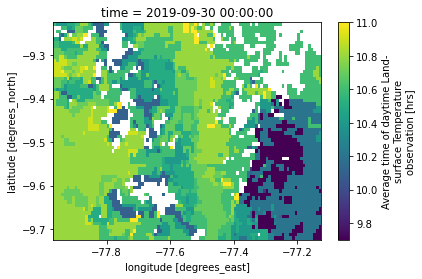

In [5]:
#lets open our data
ds = xr.open_dataset('MOD11A2.006_1km_aid0001.nc')
ds.isel(time=0)['Day_view_time'].plot()

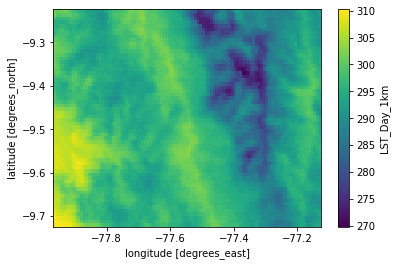

In [30]:
ds.mean(dim='time')['LST_Day_1km'].plot()

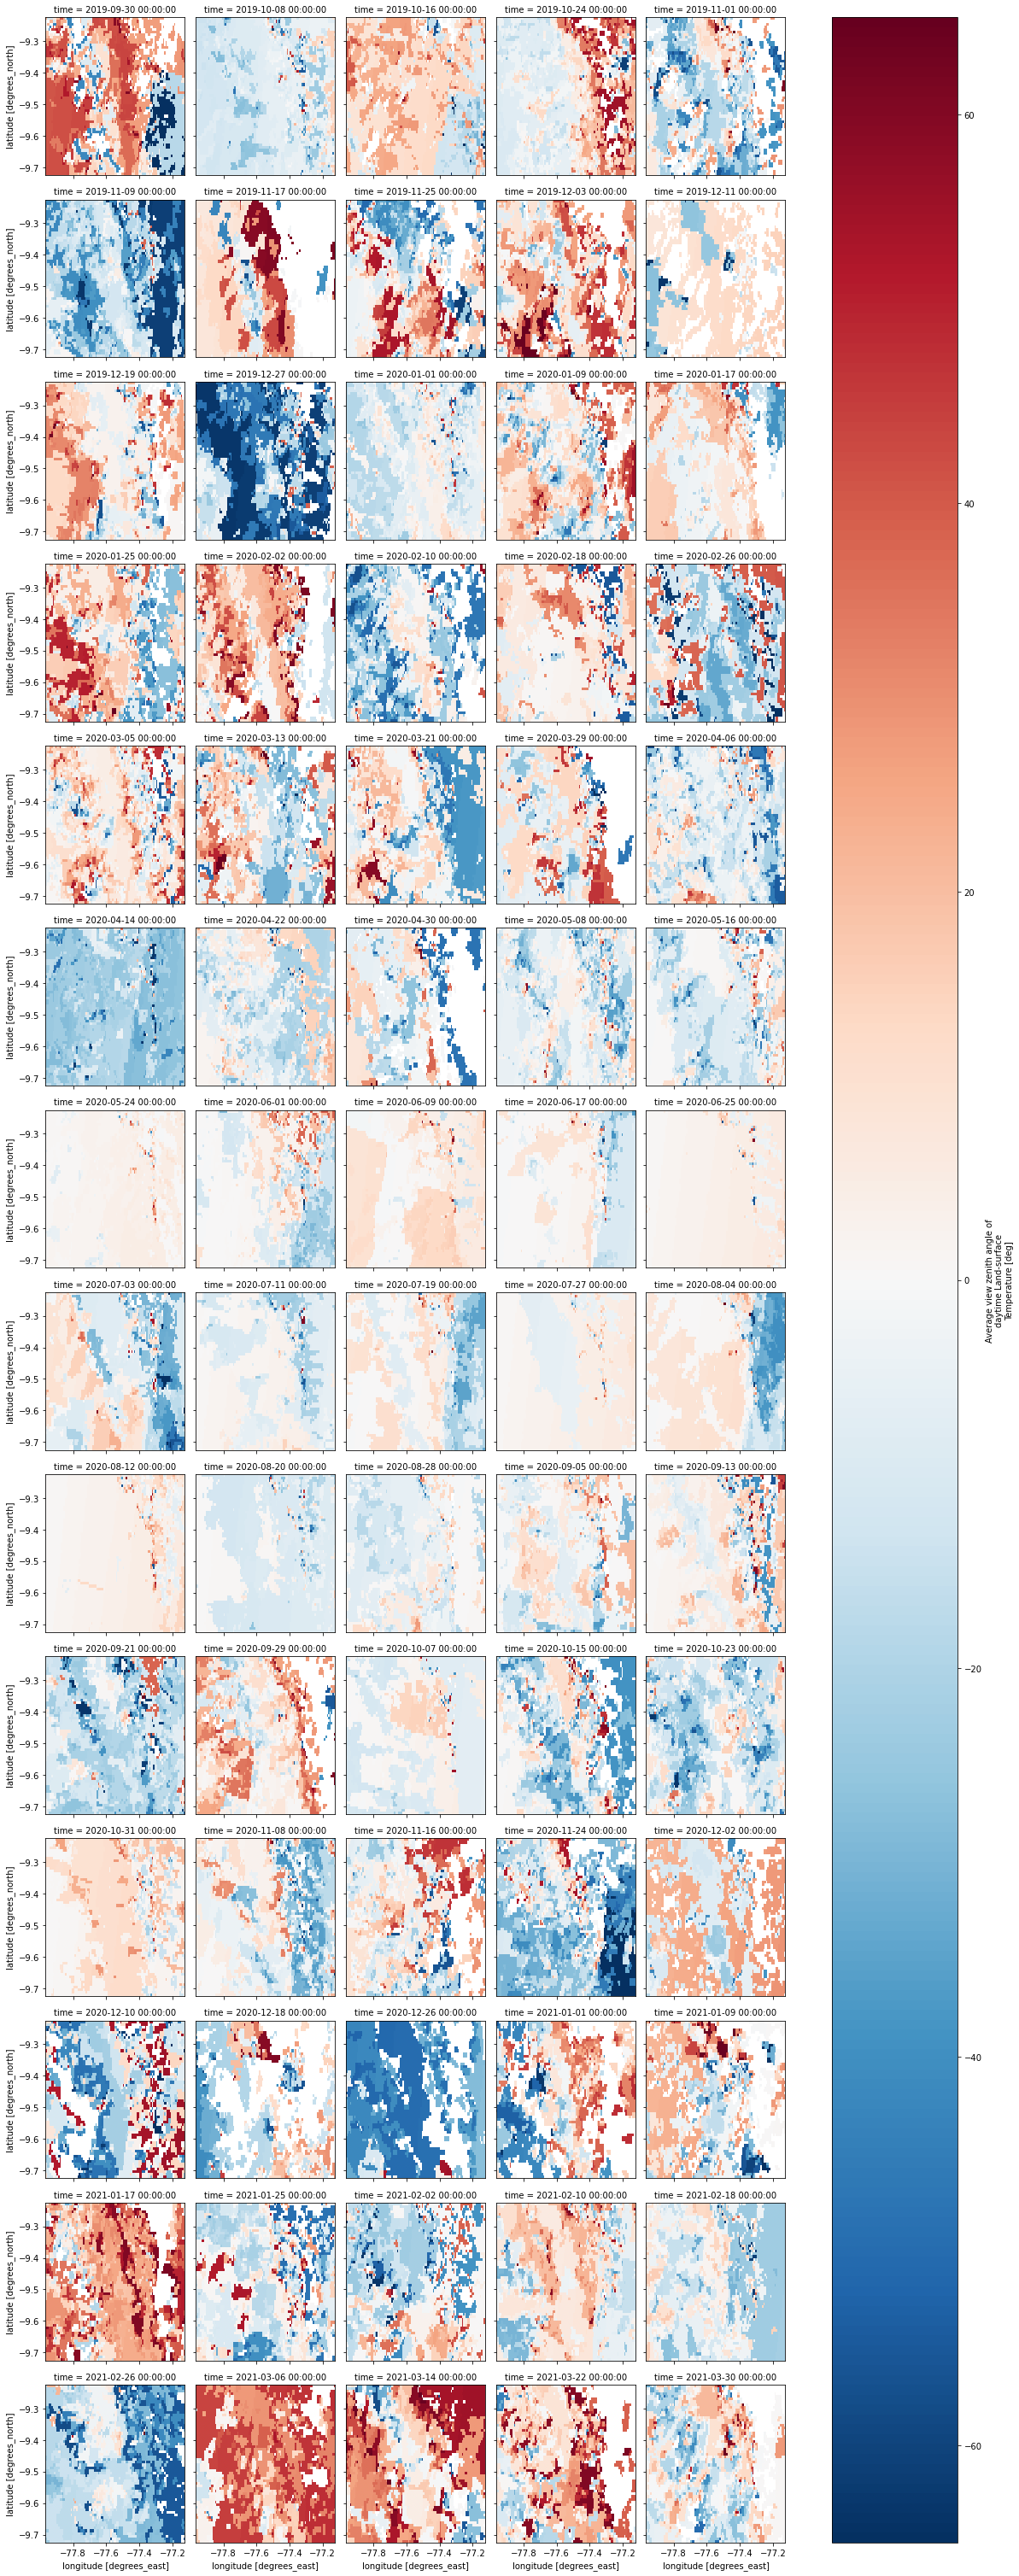

In [27]:
ds['Day_view_angl'].plot(x="lon", y="lat", col="time", col_wrap=5)

AttributeError: 'DataArray' object has no attribute 'pcolormesh'

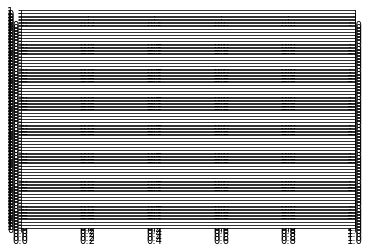

In [24]:
fig, ax = plt.subplots(len(ds.time))
for i,ax in enumerate(ds.time):
    ds.isel(time=0)['Day_view_time'].plot(ax=ax)

In [3]:
#and our lookup table
lut = glob.glob('**lookup.csv')
print(lut)

QA_lut = pd.read_csv(lut[0]) 
print(QA_lut.columns)

['MOD11A2-006-QC-Day-lookup.csv', 'MOD11A2-006-QC-Night-lookup.csv']
Index(['Value', 'MODLAND', 'Emis Error flag', 'LST Error Flag',
       'Data Quality flag'],
      dtype='object')


In [4]:
#this is kind of weird already, as you said there is no "good quality" MODLAND criteria here...
QA_lut

,Value,MODLAND,Emis Error flag,LST Error Flag,Data Quality flag
0,2,LST not produced due to cloud effects,Average emissivity error <= 0.01,Average LST error <= 1K,Good data quality
1,17,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.02,Average LST error <= 1K,Good data quality
2,33,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.04,Average LST error <= 1K,Good data quality
3,65,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.01,Average LST error <= 2K,Good data quality
4,81,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.02,Average LST error <= 2K,Good data quality
5,97,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.04,Average LST error <= 2K,Good data quality
6,129,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.01,Average LST error <= 3K,Good data quality
7,145,"LST produced, other quality, recommend examina...",Average emissivity error <= 0.02,Average LST error <= 3K,Good data quality


In [5]:
#how many pixels do we remove by filtering MODLAND > 2?
rem = ds['LST_Day_1km'].count().values - ds['LST_Day_1km'].where(ds['QC_Day'] > 2).count().values
print('{} Pixels out of {} are filtered by QA'.format(rem,ds['LST_Day_1km'].count().values))

178150 Pixels out of 387992 are filtered by QA


In [6]:
#and if we additionally remove > 145 because lets assume we dont accept 3K error?
rem = ds['LST_Day_1km'].where(ds['QC_Day']).where(ds['QC_Day'] < 145).count().values
print('{} Pixels out of {} are filtered by QA'.format(rem,ds['LST_Day_1km'].count().values))

209735 Pixels out of 387992 are filtered by QA


In [7]:
#ok thats some more, so generally the MODLAND QA filtering seems to work just fine but its A LOT of missing
#values, > 50%, thats probably not what we want...

In [8]:
#now lets check the binary information stored in the "value" column

#lets take just one day and create a np array of the QC as integers
flags = ds['QC_Day'].isel(time=20).values.astype(int)
flags


array([[         65,          65,          65, ...,          65,
                 65,          65],
       [         65,          65,          65, ...,          65,
        -2147483648, -2147483648],
       [         65,          65,          65, ...,          65,
                 65, -2147483648],
       ...,
       [         81,          81,          81, ...,           2,
                 65,          65],
       [         17,          81,          81, ...,          65,
                 65,           2],
       [         17,          81,          81, ...,          65,
                 65,          65]])

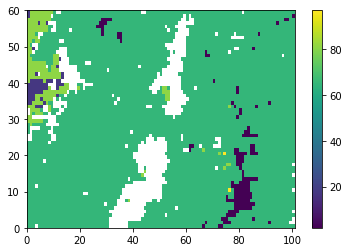

In [9]:
#OK, -2147483648 is the integer representation of NaN, so we could mask this
mask = np.ma.masked_where(flags < 0,flags)

plt.figure()
plt.pcolormesh(mask)
plt.colorbar()

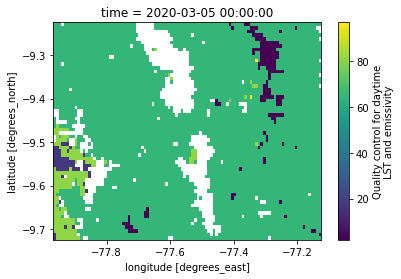

In [10]:
#but actually thats kinda useless because thats exactly what we had before (just mirrored)
ds['QC_Day'].isel(time=20).plot()

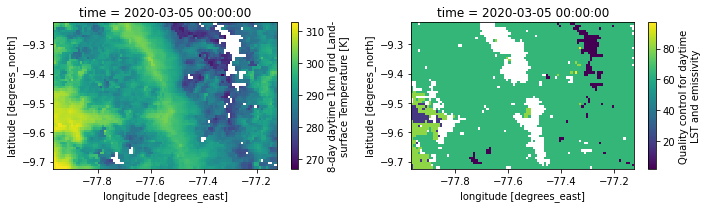

In [11]:
#Its kinda funny, because:
#1. the areas with the MODLAND = 2 are NaNs already, which makes sense as no data is produced
#2. but I dont really get those nan QC areas in the plot above, does that mean:
#a) no QC was done?
#b) no QC necessary?

fig, ax = plt.subplots(1,2,figsize=(10,3))
ds['LST_Day_1km'].isel(time=20).plot(ax=ax[0])
ds['QC_Day'].isel(time=20).plot(ax=ax[1])

plt.tight_layout()

#the data in these NaN locations looks good so probably if there is no QC you should keep it... 

#would be interesting to compare with your 1-day data if there is ANY nans in the QC layers

In [12]:
# below should be a table ("Table 13") of the Bit flags, if its not here, its in the folder

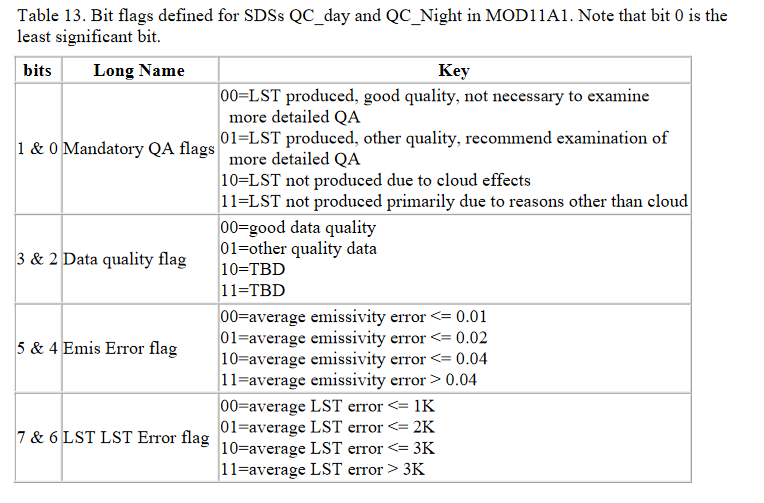

In [13]:
flags

array([[         65,          65,          65, ...,          65,
                 65,          65],
       [         65,          65,          65, ...,          65,
        -2147483648, -2147483648],
       [         65,          65,          65, ...,          65,
                 65, -2147483648],
       ...,
       [         81,          81,          81, ...,           2,
                 65,          65],
       [         17,          81,          81, ...,          65,
                 65,           2],
       [         17,          81,          81, ...,          65,
                 65,          65]])

In [14]:
#this is a binary QA (originally 65)
binary = np.flip('{0:016b}'.format(int(flags[0][0])))
#binary = ('{0:016b}'.format(int(flags[0][0])))
print(int(flags[0][0]))
print(binary)

65
0000000001000001


In [15]:
#we read it backwards so according to Table 13 this should be:
print(binary[-2],binary[-1])
print('bits 1 & 0: 01 = blabla need more QA')
print(binary[-4],binary[-3])
print('bits 3 & 2: 00 = good quality')
print(binary[-6],binary[-5])
print('bits 5 & 4: 00 = small emissitivy error')
print(binary[-8],binary[-7])
print('bits 7 & 6: 01 = Ok, here we have a bit higher LST error')

0 1
bits 1 & 0: 01 = blabla need more QA
0 0
bits 3 & 2: 00 = good quality
0 0
bits 5 & 4: 00 = small emissitivy error
0 1
bits 7 & 6: 01 = Ok, here we have a bit higher LST error


In [16]:
#lets check our MODLAND code 2 by hand
binary = np.flip('{0:016b}'.format(2))
print(binary)

#bits 1 & 0: '10' = not produced

#therefore all the others dont matter really

#this also seems good

0000000000000010


In [17]:
#now lets count and compare this just for the first 2 bits
mand_QA,dataQuali,EMISerr,LSTerr = [],[],[],[]
bit_pos1 = -2
bit_pos2 = -1

for b, i in zip(np.nditer(flags), range(flags.size)):
    bb = np.flip('{0:016b}'.format(int(b)))  #16bit
    mand_QA.append((str(bb[bit_pos1]) + str(bb[bit_pos2])))
mand_QA = np.reshape(np.array(mand_QA), flags.shape)

(unique, counts) = np.unique(mand_QA, return_counts=True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[['00' '661']
 ['01' '5243']
 ['10' '156']]


In [18]:
np.set_printoptions(suppress=True)
(unique, counts) = np.unique(ds['QC_Day'].isel(time=20),return_counts=True)
frequencies = np.asarray((unique, counts)).T
nac = 0
for row in frequencies: #there is lots of nan values so this is
    if row[0] != row[0]:
        nac +=1
    else:
        print(row.astype(int))
print([np.nan,nac])
    

[  2 156]
[17 60]
[  65 4979]
[ 81 202]
[97  2]
[nan, 661]


In [19]:
#hmm alright:
#661 nans, if we would use the binary codes for filtering they appear as '00', so data will be kept!
#if I add up all the rest which is < 2
print(2+202+4979+60)
#I get the '01' "there might be some issue" values from beforeand the [2 156] are the pixels which never
#where produced in the first place because:
print(ds['QC_Day'].isel(time=20).count().values)
print(ds['QC_Day'].isel(time=20).count().values - 156)

#maybe this might be obvious by now, but it confused me a lot, there are 0 pixels 
#where QC actually is 2 in the LST data as it never was produced!
print(ds['LST_Day_1km'].isel(time=20).where(ds['QC_Day'].isel(time=20) == 2).count().values)
#aaand the total number of values is:
print(ds['LST_Day_1km'].isel(time=20).count().values)
#so there is 
print(ds['LST_Day_1km'].isel(time=20).count().values - ds['QC_Day'].isel(time=20).count().values)
#values more in the LST layer than in the QC layer, thats a bit crazy ;)


5243
5399
5243
0
5904
505


In [20]:
#this means this statement from the beginning is actually wrong
rem = ds['LST_Day_1km'].isel(time=20).count().values - ds['LST_Day_1km'].where(ds['QC_Day'] > 2).isel(time=20).count().values
print('{} Pixels out of {} are filtered by QA'.format(rem,ds['LST_Day_1km'].isel(time=20).count().values))

#instead:
rem = ds['LST_Day_1km'].isel(time=20).count().values - ds['LST_Day_1km'].where(ds['QC_Day'].fillna(9999) > 2).isel(time=20).count().values
print('{} Pixels out of {} are filtered by QA'.format(rem,ds['LST_Day_1km'].isel(time=20).count().values))

#and consequently
print('{} Pixels appear in QA, but were never produced'.format(ds['QC_Day'].where(ds['QC_Day'] ==2).isel(time=20).count().values))


661 Pixels out of 5904 are filtered by QA
0 Pixels out of 5904 are filtered by QA
156 Pixels appear in QA, but were never produced


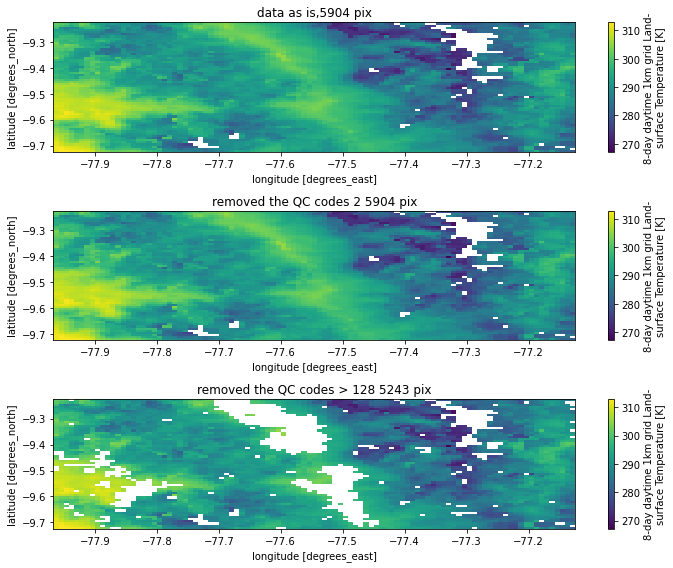

In [21]:
#so maybe we should stepwise do some test filtering like this
time = 20
fig, ax = plt.subplots(3,1,figsize=(10,8))
#original data
ds['LST_Day_1km'].isel(time=time).plot(ax=ax[0])

#lets remove code 2, although nothing should happen..
step1 = ds['LST_Day_1km'].where(ds['QC_Day'] != 2).isel(time=time)
step1.plot(ax=ax[1])

#ok, now we could say lets not allow data where the error of lst is > 2K, which is MODLAND 129 and 145
step2 = ds['LST_Day_1km'].where(ds['QC_Day'] < 129).isel(time=time)
step2.plot(ax=ax[2])

#Ok, here is a problem with those NaN values, of course they will also disappear as np.nan is
#affected by the < 129 condition. So lets re-do all of that

ax[0].set_title('data as is,{} pix'.format(ds['LST_Day_1km'].isel(time=time).count().values))
ax[1].set_title('removed the QC codes 2 {} pix'.format(step1.count().values))
ax[2].set_title('removed the QC codes > 128 {} pix'.format(step2.count().values))



plt.tight_layout()

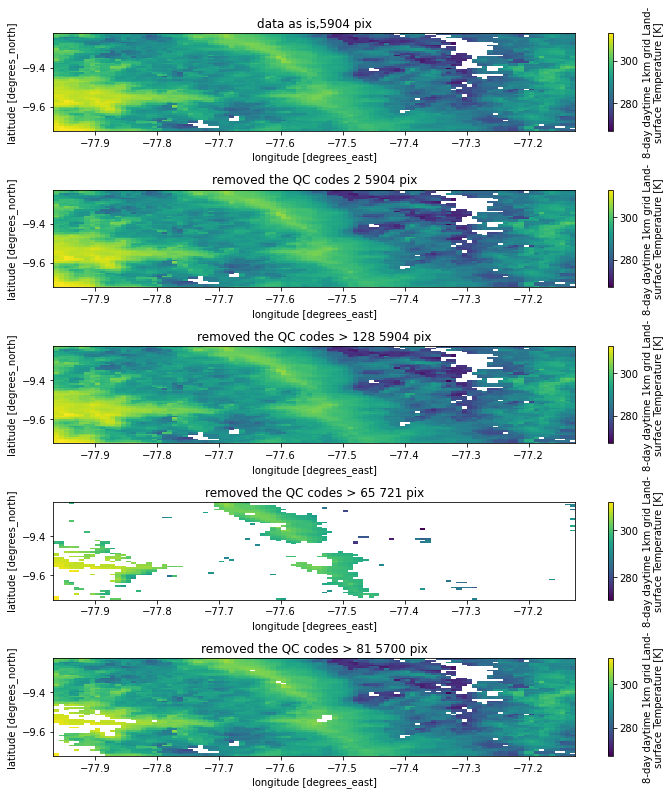

In [22]:
#so maybe we should stepwise do something like this
time = 20
fig, ax = plt.subplots(5,1,figsize=(10,11))
#original data
ds['LST_Day_1km'].isel(time=time).plot(ax=ax[0])

#lets remove code 2, although nothing should happen..
step1 = ds['LST_Day_1km'].where(ds['QC_Day'].fillna(0) != 2).isel(time=time)
step1.plot(ax=ax[1])




#ok, now we could say lets not allow data where the error of lst is > 2K, which is MODLAND 129 and 145
step2 = ds['LST_Day_1km'].where(ds['QC_Day'].fillna(0) < 129).isel(time=time)
step2.plot(ax=ax[2])

#Ok, I replaced the nans with zeros, but nothing happened. Just checked above, 129 and 145 just dont exist
#in this particular scene so lets say we remove everything above 65

step3 = ds['LST_Day_1km'].where(ds['QC_Day'].fillna(0) < 65).isel(time=time)
step3.plot(ax=ax[3])

#this is quite radical as we lose most of our data (QC == 65), so maybe lets keep 65, but remove > 81

step4 = ds['LST_Day_1km'].where(ds['QC_Day'].fillna(0) < 81).isel(time=time)
step4.plot(ax=ax[4])

#cool now we removed some uncertain data but kept most of the rest..

ax[0].set_title('data as is,{} pix'.format(ds['LST_Day_1km'].isel(time=time).count().values))
ax[1].set_title('removed the QC codes 2 {} pix'.format(step1.count().values))
ax[2].set_title('removed the QC codes > 128 {} pix'.format(step2.count().values))
ax[3].set_title('removed the QC codes > 65 {} pix'.format(step3.count().values))
ax[4].set_title('removed the QC codes > 81 {} pix'.format(step4.count().values))



plt.tight_layout()

In [45]:
#lets iterate over these periods and save the DataSets in a list so they will be easily accessible
years = []
for year in np.arange(2019,2022,1):
    years.append(ds['LST_Day_1km'].sel(time=str(year)))

    
#Next we could mask for crops and check data availability after QA
bigcount = []
for i in range(len(years)):
    smallcount = []
    for j in range(len(years[i].time)):
        #pixel counting
        smallcount.append(int(years[i].isel(time=j).count().values))
    #print('small',len(smallcount))
    bigcount.append(smallcount)